In [1]:
from data_prep.data_prep import prepare_all_data
from training.training import prepare_model_data
from model import burglary_model
from utils.utils import single_out_last, setup_reproducibility
from pipeline import train_and_evaluate_model
model_tuple, occupation_mappings,ward_idx_map = prepare_all_data("../merged_data.parquet", "lsoa")

In [2]:
device = setup_reproducibility(42)
print(f'Using device: {device}')
training_data, testing_data = single_out_last(model_tuple[0])

Using device: cuda


In [3]:

model_tuple = (
    model_tuple[0],
['Ethnic Group|BAME (%)', 'Car or van availability|No cars or vans in household (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'n_neighbors', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|3', 'Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65', 'Household Composition|% One person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Ethnic Group|Asian/Asian British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Car or van availability|1 car or van in household (%)', 'Ethnic Group|Other ethnic group (%)', 'Tenure|Owned with a mortgage or loan (%)', 'Car or van availability|2 cars or vans in household (%)'],
['Mid-year Population Estimates|All Ages', 'Mid-year Population Estimates|Aged 0-15', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 45-64', 'Employment Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)'],
["post_corona", "month_sin"],
['time_log'],
['lag_1'],
['lag1_diff_neighbors', 'lag1_mean_neighbors', 'lag_1_x_n_neighbors']
)

In [4]:
train_data = prepare_model_data(training_data, *model_tuple[1:], device, ward_idx_map=ward_idx_map)
test_data = prepare_model_data(testing_data, *model_tuple[1:], device, train_data["means"], train_data["stds"], ward_idx_map)

evaluation_metrics, svi, svi.guide, prediction_tester = train_and_evaluate_model(train_data, test_data, burglary_model, occupation_mappings[1], testing_steps=5000)

Training SVI: 100%|██████████| 500/500 [00:28<00:00, 17.59it/s]


In [5]:
evaluation_metrics

{'rmse': np.float32(1.4459786),
 'mae': np.float32(0.8442788),
 'crps': 0.649685818187486}

# Explainability

In [6]:
# posterior predictive samples:   preds  (shape: [S, N])   – integers
# posterior rate samples:         lam    (shape: [S, N])   – reals
# design-matrix DataFrame:        X_df   (one row per LSOA month)
# original GeoJSON for LSOAs:     lsoa_geo
import geopandas as gpd
preds = prediction_tester.predictions["obs"].cpu().numpy()    # shape (1000, N)
lam   = prediction_tester.predictions["lam"].cpu().numpy()    # shape (1000, N)
X_df = testing_data.copy()
X_df["lsoa"] = X_df["occupation_idx"].map(occupation_mappings[1])
lsoa_geo = gpd.read_file("../processed_data/LSOA boundaries.geojson")

In [7]:
X_df["lsoa"]

171       E01000001
343       E01000002
515       E01000003
687       E01000005
859       E01000006
            ...    
853119    E01035688
853291    E01035689
853463    E01035690
853635    E01035691
853807    E01035692
Name: lsoa, Length: 4964, dtype: object

In [8]:
lsoa_geo = lsoa_geo[["LSOA21CD", "geometry"]].rename(columns={"LSOA21CD": "lsoa"}).copy()

In [9]:
X_df["burglaries"]

171       0.0
343       0.0
515       1.0
687       1.0
859       0.0
         ... 
853119    4.0
853291    0.0
853463    4.0
853635    0.0
853807    3.0
Name: burglaries, Length: 4964, dtype: float32

In [10]:
X_df[["occupation_idx", "burglaries"]].assign(lsoa=X_df["occupation_idx"].map(occupation_mappings[1])).set_index("lsoa")[["burglaries"]]

,burglaries
lsoa,
E01000001,0.0
E01000002,0.0
E01000003,1.0
E01000005,1.0
E01000006,0.0
...,...
E01035688,4.0
E01035689,0.0
E01035690,4.0


In [11]:
prediction_tester.get_confidence_intervals(0.05)

,lower_bound,upper_bound
E01000001,0.0,2.0
E01000002,0.0,2.0
E01000003,0.0,4.0
E01000005,0.0,9.0
E01000006,0.0,7.0
...,...,...
E01035688,0.0,11.0
E01035689,0.0,4.0
E01035690,0.0,2.0
E01035691,0.0,1.0


In [12]:
prediction_tester.get_confidence_intervals(0.05).reset_index(names="lsoa")

,lsoa,lower_bound,upper_bound
0,E01000001,0.0,2.0
1,E01000002,0.0,2.0
2,E01000003,0.0,4.0
3,E01000005,0.0,9.0
4,E01000006,0.0,7.0
...,...,...,...
4959,E01035688,0.0,11.0
4960,E01035689,0.0,4.0
4961,E01035690,0.0,2.0
4962,E01035691,0.0,1.0


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume you already have:
#   ci_df       : DataFrame with columns ["lsoa", "lower_bound", "upper_bound"]
#   summary_df  : DataFrame with columns ["lsoa", "burglaries_observed"] (and possibly other cols)
summary_df = X_df[["occupation_idx", "burglaries"]].assign(lsoa=X_df["occupation_idx"].map(occupation_mappings[1])).set_index("lsoa")[["burglaries"]].reset_index()

In [ ]:
import numpy as np
alphas = np.arange(0.05, 1, 0.05)
coverages = []
confidence_intervals = []
for alpha in alphas:
    ci_df = prediction_tester.get_confidence_intervals(alpha).reset_index(names="lsoa")
    test = ci_df.merge(summary_df, on="lsoa", how="left")
    test["contained"] = (test["lower_bound"] <= test["burglaries"]) &  (test["burglaries"] <= test["upper_bound"])
    coverages.append(test["contained"].mean() * 100)
    confidence_intervals.append((test["upper_bound"] - test["lower_bound"]).mean())

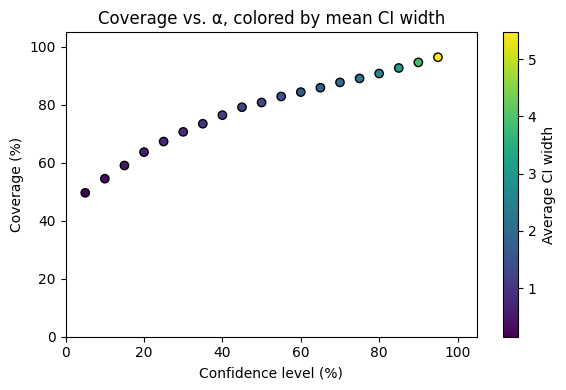

In [15]:
import numpy as np
import matplotlib.pyplot as plt

confidence = (1 - alphas) * 100  
# 2. Scatter plot: alpha vs coverage, colored by mean CI width
fig, ax = plt.subplots(figsize=(6, 4))
sc = ax.scatter(confidence, coverages, c=confidence_intervals, cmap='viridis', edgecolor='k')
ax.set_xlabel("Confidence level (%)")
ax.set_ylabel("Coverage (%)")
ax.set_title("Coverage vs. α, colored by mean CI width")
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Average CI width")
plt.tight_layout()
plt.show()


In [29]:
from testing.testing import StatisticalTester
factors_map ={
    "b_static": model_tuple[1],
    "b_dynamic": model_tuple[2],
    "b_seasonal": model_tuple[3],
    "b_time_tr": model_tuple[4],
    "b_temporal": model_tuple[5],
    "b_spatial": model_tuple[6],
}
statistical_tester = StatisticalTester(test_data, burglary_model, svi.guide, factors_map)

In [30]:
statistical_tester.predict(5000)

In [31]:
frames = statistical_tester.evaluate_all()

In [33]:
frames["b_static"]

,col,mean,ci_lower,ci_upper,p_val,significant_CI
0,Public Transport Accessibility Levels|Number o...,0.336057,0.166892,0.508910,0.0000,Yes
1,Tenure|Owned with a mortgage or loan (%),0.235277,0.061888,0.408886,0.0064,Yes
2,Ethnic Group|BAME (%),-0.197235,-0.379948,-0.009897,0.0412,Yes
3,Car or van availability|No cars or vans in hou...,-0.189695,-0.374572,-0.003571,0.0460,Yes
4,Ethnic Group|Black/African/Caribbean/Black Bri...,-0.177392,-0.359024,0.001001,0.0516,No
5,Public Transport Accessibility Levels|Number o...,0.158322,-0.013438,0.334328,0.0724,No
6,Public Transport Accessibility Levels|Number o...,0.115914,-0.071259,0.299196,0.2228,No
7,Public Transport Accessibility Levels|Number o...,-0.104491,-0.298276,0.092798,0.3060,No
8,Car or van availability|1 car or van in househ...,-0.089965,-0.274331,0.093429,0.3304,No
9,Ethnic Group|Other ethnic group (%),0.071272,-0.103224,0.244783,0.4308,No


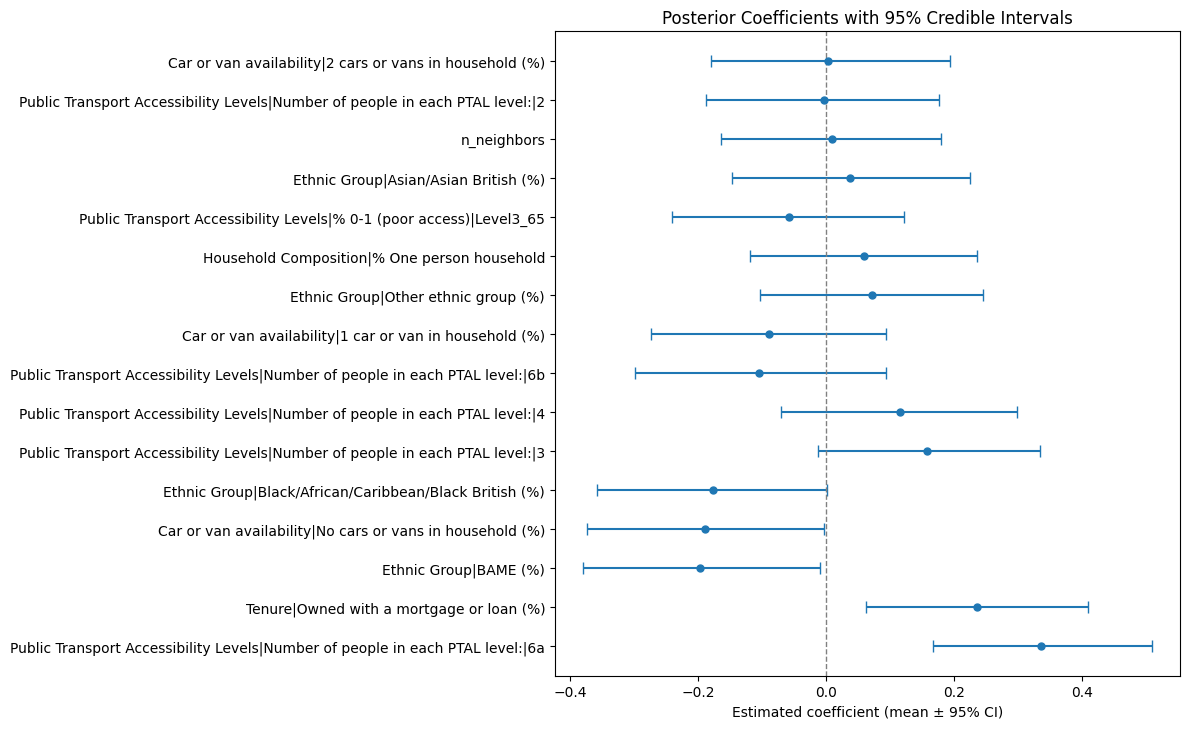

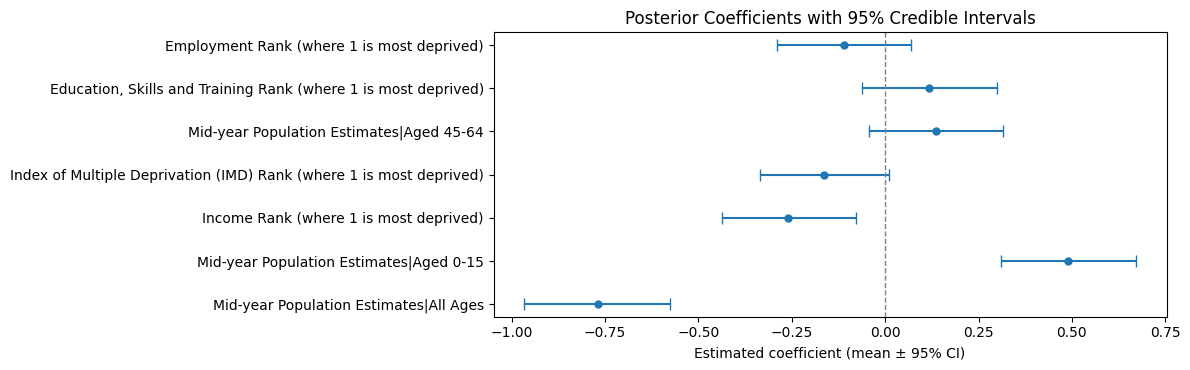

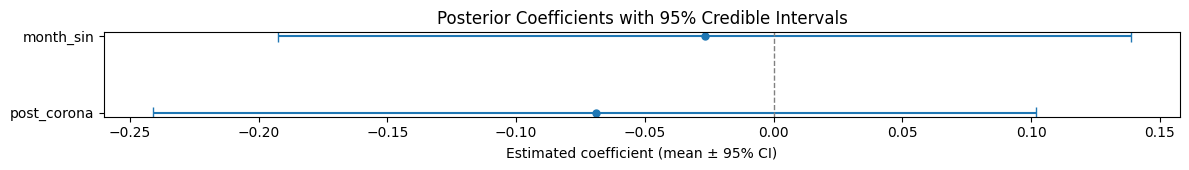

c:\MiniConda\envs\py311\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


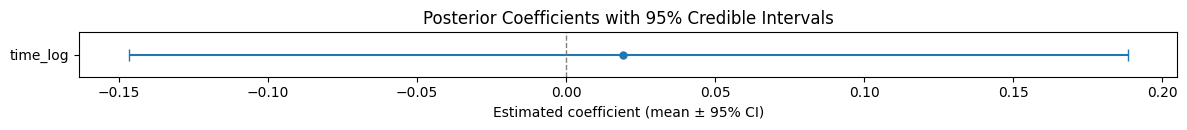

c:\MiniConda\envs\py311\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


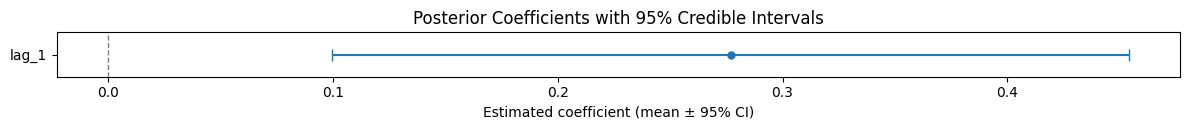

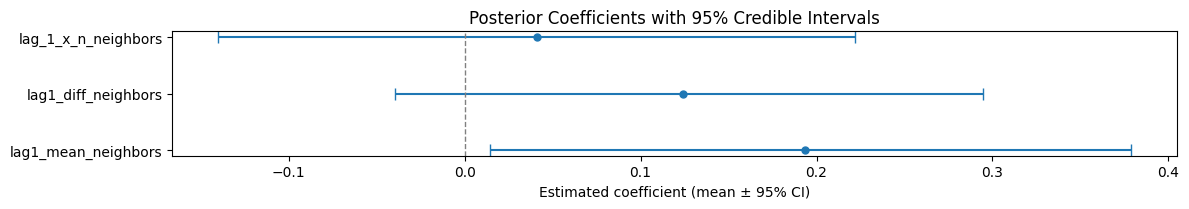

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assume your DataFrame is named `df` with columns: 'col', 'mean', 'ci_lower', 'ci_upper'
# Example: df = pd.DataFrame({...})
for value in frames.values():
    df = value.copy()
    # 1. Compute the lower and upper error magnitudes
    lower_err = df['mean'] - df['ci_lower']
    upper_err = df['ci_upper'] - df['mean']

    # 2. Prepare figure
    fig, ax = plt.subplots(figsize=(12, 0.4 * len(df) + 1))

    # 3. Plot error bars horizontally
    ypos = np.arange(len(df))
    ax.errorbar(df['mean'], ypos, xerr=[lower_err, upper_err],
                fmt='o', capsize=4, markersize=5)

    # 4. Add aesthetics
    ax.set_yticks(ypos)
    ax.set_yticklabels(df['col'])
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel('Estimated coefficient (mean ± 95% CI)')
    ax.set_title('Posterior Coefficients with 95% Credible Intervals')
    plt.tight_layout()
    plt.show()


In [39]:
prediction_tester.predictions["lam"].cpu().numpy()

array([[0.12917872, 0.23170948, 0.42444462, ..., 0.48870146, 0.09237088,
        0.5500755 ],
       [0.11923312, 0.17060585, 0.33841065, ..., 0.40727368, 0.14219482,
        0.897981  ],
       [0.27179608, 0.22001393, 1.205504  , ..., 0.35688934, 0.13214837,
        0.39734596],
       ...,
       [0.12304113, 0.18389596, 0.37328312, ..., 0.5315385 , 0.1757772 ,
        1.3834046 ],
       [0.14688884, 0.18694603, 0.95996267, ..., 0.720989  , 0.13615029,
        1.5155084 ],
       [0.04432394, 0.09097984, 0.75425124, ..., 0.39193252, 0.07691783,
        1.1214617 ]], shape=(5000, 4964), dtype=float32)

In [41]:
import arviz as az

# assume your posterior is in an `InferenceData` called `idata`
az.plot_forest(idata, var_names=["b_static","b_dynamic"], combined=True)
plt.show()


NameError: name 'idata' is not defined